In [2]:
import os
import numpy as np
import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cv2

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import dlib
import face_recognition
import pickle
import datetime
from PIL import Image
from pathlib import Path

%matplotlib inline

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [2]:
# Проверка доступности библиотеки torch
torch.cuda.is_available()

True

In [3]:
# Проверка доступности библиотеки dlib и версии этой библиотеки
dlib.__version__

'19.22.0'

In [4]:
# Проверка доступности библиотеки sklearn и версии этой библиотеки
sklearn.__version__

'0.24.2'

In [5]:
# Функция для вычисления площади шестиугольника, ограничивающего глаз (левый или правый).
# В функции используется разделение шестиугольника на 6 треугольников, т.е.
# реализован метод триангуляции

# Функция перенесена в отдельный файл get_eye_square.py

def get_eye_square(eye_points, eye_center):
    squares_sum = 0
    for i in range(0, 6):
        point_a = eye_points[(i % 6)]
        point_b = eye_points[((i + 1) % 6)]
        point_c = eye_center

        a = np.sqrt((point_b.x - point_c['x']) ** 2 + (point_b.y - point_c['y']) ** 2)
        b = np.sqrt((point_a.x - point_c['x']) ** 2 + (point_a.y - point_c['y']) ** 2)
        c = np.sqrt((point_a.x - point_b.x) ** 2 + (point_a.y - point_b.y) ** 2)

        # Вычисление полупериметра
        p = (a + b + c) / 2.0
        
        # Для вычисления площади треугольника используется формула Герона
        if p > a and p > b and p > c:
            s = np.sqrt(p * (p - a) * (p - b) * (p - c))
        else:
            s = 0
        squares_sum += s
    return squares_sum

In [6]:
# Функция для вычисления расстояния между левым и правым глазами

def get_eyes_distance(r_center, l_center):
    squared_distance = (r_center['x'] - l_center['x']) ** 2 + (r_center['y'] - l_center['y']) ** 2
    if squared_distance > 0:
        distance = np.sqrt(squared_distance)
    else:
        distance = 1
    return distance

In [7]:
# Функция для вычисления расстояния между произвольными двумя точками

# Функция перенесена в отдельный файл get_distance.py

def get_distance(one, two):
    squared_distance = (one.x - two.x) ** 2 + (one.y - two.y) ** 2
    if squared_distance > 0:
        distance = np.sqrt(squared_distance)
    else:
        distance = 1
    return distance

In [8]:
# Функция для вычисления угла в градусах по координатам трех точек

# Функция перенесена в отдельный файл get_angle.py

def get_angle(A, C, B):
    CA_CB = (A.x - C.x)*(B.x - C.x) +  (A.y - C.y)*(B.y - C.y)
    abs_CA = get_distance(A, C)
    abs_CB = get_distance(B, C)
    cos_C = CA_CB / (abs_CA * abs_CB)
    angle = round(np.arccos(cos_C)/ np.pi * 180, 1)
    return angle

In [9]:
# Функция для вычисления периметра многоугольника по координатам его вершин
# (при определении состояния глаза используется вычисление периметра
# по 6 точкам глаза)

# Функция перенесена в отдельный файл get_perimeter.py

def get_perimeter(eye_points):
    perimeter = 0
    for i in range(0, 6):
        segment = get_distance(eye_points[((i + 1) % 6)], eye_points[(i % 6)])
        perimeter += segment
    return perimeter

In [12]:
# Функция для определения параметров левого и правого глаза
# Для каждого глаза определяются следующие параметры:
#   - площадь многоугольника, ограничивающего глаз ("площадь глаза")
#   - периметр многоугольника, ограничивающего глаз ("периметр глаза")
#   - угол многоугольника глаза у виска ("внешний" угол глаза)
#   - угол многоугольника глаза у носа ("внутренний угол глаза")
#   - расстояние между нижним и верхним веками глаза у виска ("внешнее расстояние")
#   - расстояние между нижним и верхним веками глаза у носа ("внутреннее" расстояние)
# Для вычисления используются координаты контрольных точек лица

# Функция перенесена в отдельный файл get_eyes_state.py

def get_eyes_state(folder, state):
    directory = folder
    files = os.listdir(directory)
    os.chdir(directory)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("D:/ML/Stepik/NN_CV/models/shape_predictor_68_face_landmarks.dat")
    
    images_list = []
    
    right_eye_squares_list = []
    right_eye_perimeter_list = []
    right_eye_out_angles_list = []
    right_eye_in_angles_list = []
    right_eye_out_dist_list = []
    right_eye_in_dist_list = []
    
    left_eye_squares_list = []
    left_eye_perimeter_list = []
    left_eye_out_angles_list = []
    left_eye_in_angles_list = [] 
    left_eye_out_dist_list = []
    left_eye_in_dist_list = []

    for i in range(len(files)):
        msg = files[i]
        
        img = cv2.imread(files[i])
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        faces = detector(frame)
        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(frame, face)

            if len(landmarks.parts()) > 0:
                # Определение параметров правого глаза
                right_eye = []
                r_all_x = 0
                r_all_y = 0
                for n in range(36, 42):
                    right_eye.append(landmarks.part(n))
                    r_all_x += landmarks.part(n).x
                    r_all_y += landmarks.part(n).y
    
                center_x = int(r_all_x / 6)
                center_y = int(r_all_y / 6)
                right_eye_center = {'x': center_x, 'y': center_y}


                right_eye_square = get_eye_square(right_eye, right_eye_center)

                # Определение параметров левого глаза
                left_eye = []
                l_all_x = 0
                l_all_y = 0
                for n in range(42, 48):
                    left_eye.append(landmarks.part(n))
                    l_all_x += landmarks.part(n).x
                    l_all_y += landmarks.part(n).y

                center_x = int(l_all_x / 6)
                center_y = int(l_all_y / 6)
                left_eye_center = {'x': center_x, 'y': center_y}

                left_eye_square = get_eye_square(left_eye, left_eye_center)

                # Ширина глаза (расстояние между внешним и внутренним углами)
                # используется для нормировки
                r_eye_width = get_distance(landmarks.part(36), landmarks.part(39))
                l_eye_width = get_distance(landmarks.part(42), landmarks.part(45))

                # Площадь нормируется на квадрат ширины глаза
                normed_right_eye_square = round(right_eye_square / (r_eye_width ** 2), 4)
                normed_left_eye_square = round(left_eye_square / (l_eye_width ** 2), 4)
                
                # Периметр нормируется на ширину глаза
                right_eye_perimeter =  round(get_perimeter(right_eye) / r_eye_width, 3)
                left_eye_perimeter =  round(get_perimeter(left_eye) / l_eye_width, 3)
                
                
                r_out_angle = get_angle(landmarks.part(37), landmarks.part(36), landmarks.part(41))
                r_in_angle = get_angle(landmarks.part(38), landmarks.part(39), landmarks.part(40))
                l_out_angle = get_angle(landmarks.part(44), landmarks.part(45), landmarks.part(46))
                l_in_angle = get_angle(landmarks.part(43), landmarks.part(42), landmarks.part(47))
                
                r_in_dist = round(get_distance(landmarks.part(38), landmarks.part(40)) / r_eye_width, 3)
                r_out_dist = round(get_distance(landmarks.part(37), landmarks.part(41)) / r_eye_width, 3)
                l_in_dist = round(get_distance(landmarks.part(43), landmarks.part(47)) / l_eye_width, 3)
                l_out_dist = round(get_distance(landmarks.part(44), landmarks.part(46)) / l_eye_width, 3)
                
                msg = msg + ' face was found' + ' and landmarks were found.'
            else:
                normed_right_eye_square = None
                normed_left_eye_square = None
                msg = msg + ' face was found' + ' but landmarks were not found'
        else:
            normed_rigth_eye_square = None
            normed_left_eye_square = None
            msg = msg + ' face was not found'
        
#         print(msg)

        images_list.append(files[i])
    
        right_eye_squares_list.append(normed_right_eye_square)
        right_eye_perimeter_list.append(right_eye_perimeter)
        right_eye_out_angles_list.append(r_out_angle)
        right_eye_in_angles_list.append(r_in_angle)
        right_eye_out_dist_list.append(r_out_dist)
        right_eye_in_dist_list.append(r_in_dist)
        
        
        left_eye_squares_list.append(normed_left_eye_square)
        left_eye_perimeter_list.append(left_eye_perimeter)
        left_eye_out_angles_list.append(l_out_angle)
        left_eye_in_angles_list.append(l_in_angle)
        left_eye_out_dist_list.append(l_out_dist)
        left_eye_in_dist_list.append(l_in_dist)

    state = [state] * len(images_list)
    
    df = pd.DataFrame(list(zip(images_list,
                               right_eye_squares_list,
                               right_eye_perimeter_list,
                               right_eye_out_angles_list,
                               right_eye_in_angles_list,
                               right_eye_out_dist_list,
                               right_eye_in_dist_list,
                               
                               left_eye_squares_list,
                               left_eye_perimeter_list,
                               left_eye_out_angles_list,
                               left_eye_in_angles_list,
                               left_eye_out_dist_list,
                               left_eye_in_dist_list,
                               
                               state)),
             columns = ['image', 
                        'r_square', 'r_perimeter', 'r_out_angle', 'r_in_angle', 'r_out_dist', 'r_in_dist',
                        'l_square', 'l_perimeter', 'l_out_angle', 'l_in_angle', 'l_out_dist', 'l_in_dist',
                        'state'])
    return df

Для четырех человек были зарегистрированы изображения с закрытыми и открытыми глазами.
Для каждого человека было зарегистрировано 2200 изображений с закрытыми и 2200 изображений с открытыми глазами.
Общий объем выборки составил 17600 изображений.
Для регистрации использовалась web-камера Logitech C920 HD Pro Webcam.
Регистрация осуществлялась в цветовом пространстве RGB c разрешением 640x480 пикселей.
В последующих блоках кода осуществляется обработка предварительно зарегистрированных изображений.

In [13]:
# andrew
andrew_closed = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_closed/andrew', 'closed')
andrew_closed.head()

,image,r_square,r_perimeter,r_out_angle,r_in_angle,r_out_dist,r_in_dist,l_square,l_perimeter,l_out_angle,l_in_angle,l_out_dist,l_in_dist,state
0,img_0000.png,0.0996,2.050,25.6,24.0,0.152,0.148,0.0876,2.039,22.4,21.8,0.129,0.133,closed
1,img_0001.png,0.1003,2.050,25.6,24.0,0.152,0.152,0.0726,2.028,16.0,20.0,0.098,0.124,closed
2,img_0002.png,0.0996,2.050,25.6,24.0,0.152,0.148,0.0929,2.046,21.0,24.4,0.128,0.156,closed
3,img_0003.png,0.0805,2.037,23.0,16.7,0.142,0.109,0.0827,2.035,21.0,20.0,0.129,0.125,closed
4,img_0004.png,0.0924,2.048,23.0,21.8,0.141,0.141,0.0851,2.036,23.0,20.0,0.129,0.129,closed


In [14]:
# andrew
andrew_opened = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_opened/andrew', 'opened')
andrew_opened.head()

,image,r_square,r_perimeter,r_out_angle,r_in_angle,r_out_dist,r_in_dist,l_square,l_perimeter,l_out_angle,l_in_angle,l_out_dist,l_in_dist,state
0,img_0000.png,0.1955,2.137,49.6,46.2,0.288,0.286,0.1804,2.123,45.0,43.3,0.267,0.265,opened
1,img_0001.png,0.1853,2.124,47.5,42.3,0.276,0.276,0.1814,2.137,45.0,42.3,0.268,0.266,opened
2,img_0002.png,0.2000,2.155,53.0,43.6,0.310,0.277,0.1782,2.141,44.2,39.9,0.265,0.267,opened
3,img_0003.png,0.1980,2.147,54.2,42.3,0.312,0.276,0.1732,2.115,45.0,39.7,0.259,0.257,opened
4,img_0004.png,0.1980,2.147,54.2,42.3,0.312,0.276,0.1774,2.126,44.2,41.1,0.264,0.266,opened


In [15]:
# tatjana
tatjana_closed = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_closed/tatjana', 'closed')
tatjana_opened = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_opened/tatjana', 'opened')

In [16]:
# elena
elena_closed = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_closed/elena', 'closed')
elena_opened = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_opened/elena', 'opened')

In [17]:
# alexej
alexej_closed = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_closed/alexej', 'closed')
alexej_opened = get_eyes_state('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_opened/alexej', 'opened')

In [18]:
andrew = pd.concat([andrew_closed, andrew_opened], axis = 0)

In [19]:
tatjana = pd.concat([tatjana_closed, tatjana_opened], axis = 0)

In [20]:
elena = pd.concat([elena_closed, elena_opened], axis = 0)

In [21]:
alexej = pd.concat([alexej_closed, alexej_opened], axis = 0)

In [22]:
# Объединение выборок всех участников эксперимента в одну
all_people = pd.concat([andrew, tatjana, elena, alexej], axis = 0)

In [23]:
all_people.shape

(17600, 14)

In [24]:
# Сохранение набора данных в файл формата .csv для последующего использования
# без необходимости повторной обработки большого количества изображений
all_people.to_csv('D:/ML/Stepik/NN_CV/eyes_states_dataset/eyes_states.csv', index=False)

In [1]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(andrew.loc[andrew['state'] == 'closed', 'r_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(andrew.loc[andrew['state'] == 'opened', 'r_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь правого глаза для состояний открытых и закрытых глаз \n(для Andrew)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

NameError: name 'plt' is not defined

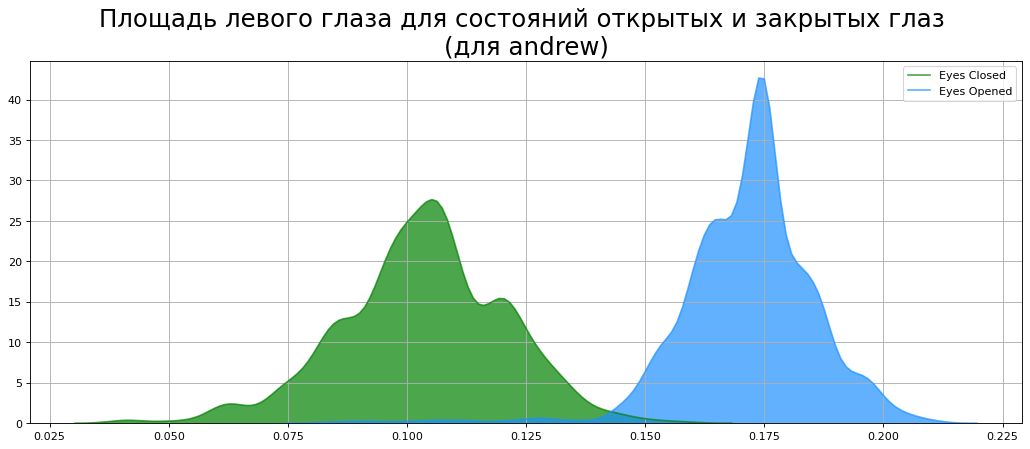

In [47]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(andrew.loc[andrew['state'] == 'closed', 'l_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(andrew.loc[andrew['state'] == 'opened', 'l_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь левого глаза для состояний открытых и закрытых глаз \n(для andrew)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

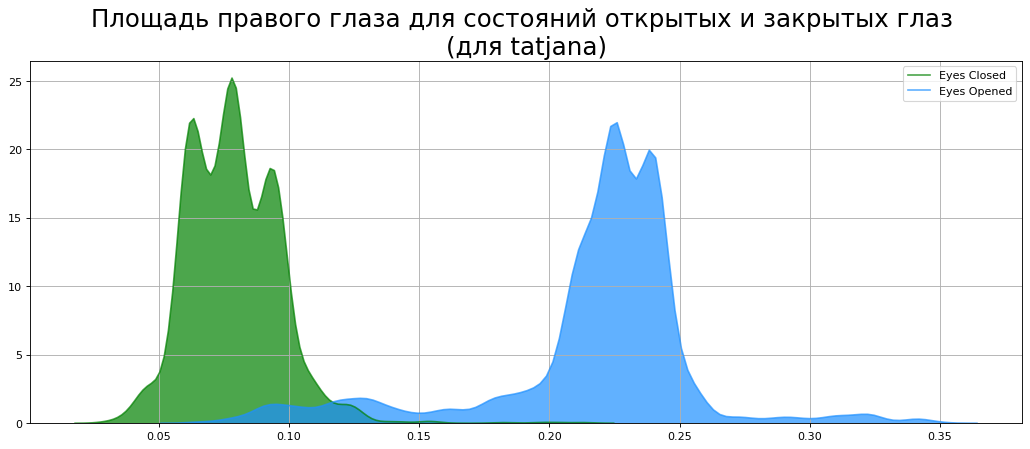

In [46]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(tatjana.loc[tatjana['state'] == 'closed', 'r_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(tatjana.loc[tatjana['state'] == 'opened', 'r_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь правого глаза для состояний открытых и закрытых глаз \n(для tatjana)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

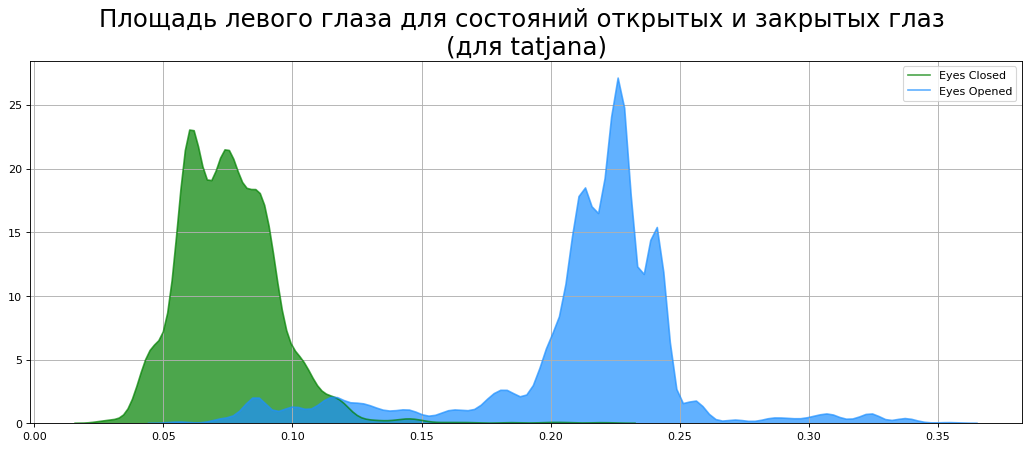

In [45]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(tatjana.loc[tatjana['state'] == 'closed', 'l_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(tatjana.loc[tatjana['state'] == 'opened', 'l_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь левого глаза для состояний открытых и закрытых глаз \n(для tatjana)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

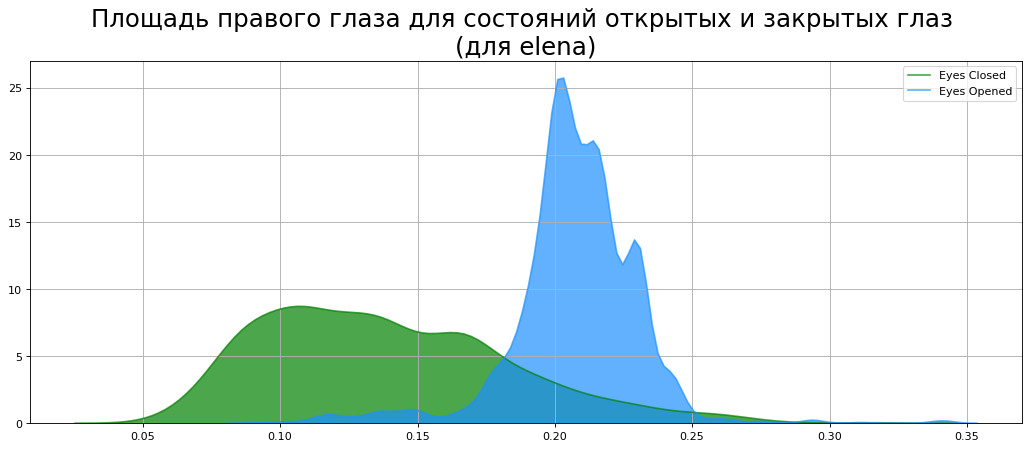

In [44]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(elena.loc[elena['state'] == 'closed', 'r_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(elena.loc[elena['state'] == 'opened', 'r_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь правого глаза для состояний открытых и закрытых глаз \n(для elena)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

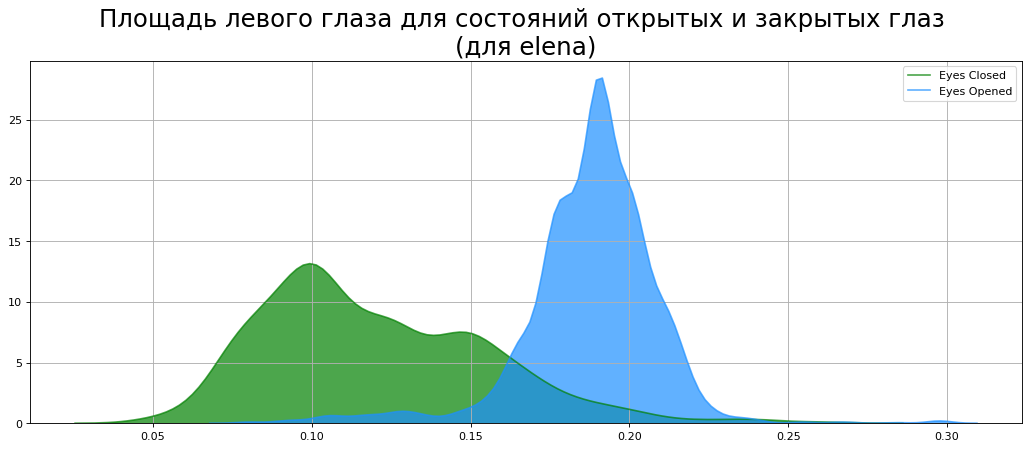

In [43]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(elena.loc[elena['state'] == 'closed', 'l_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(elena.loc[elena['state'] == 'opened', 'l_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь левого глаза для состояний открытых и закрытых глаз \n(для elena)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

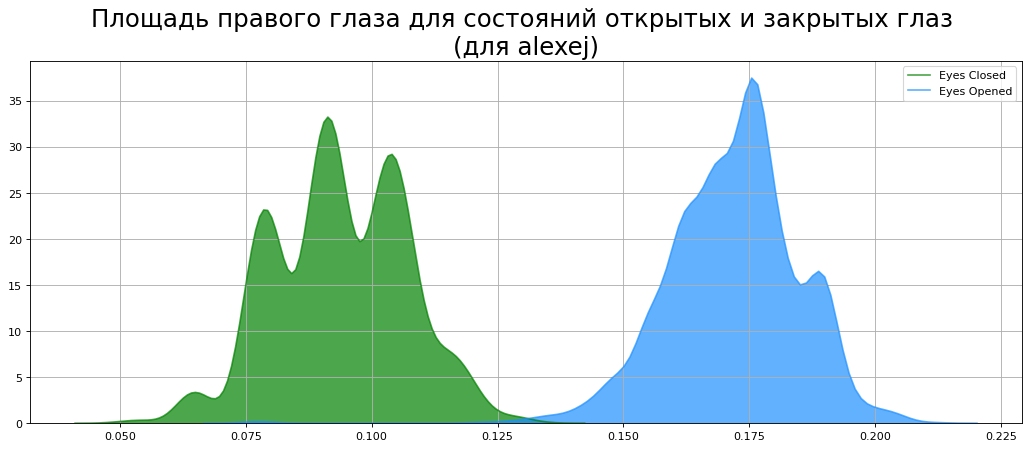

In [42]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(alexej.loc[alexej['state'] == 'closed', 'r_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(alexej.loc[alexej['state'] == 'opened', 'r_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь правого глаза для состояний открытых и закрытых глаз \n(для alexej)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

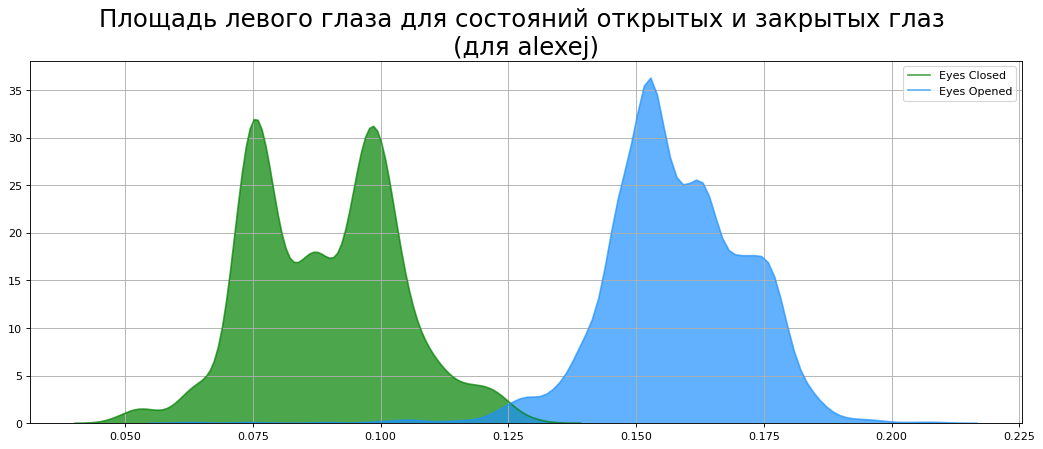

In [41]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(alexej.loc[alexej['state'] == 'closed', 'l_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(alexej.loc[alexej['state'] == 'opened', 'l_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь левого глаза для состояний открытых и закрытых глаз \n(для alexej)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

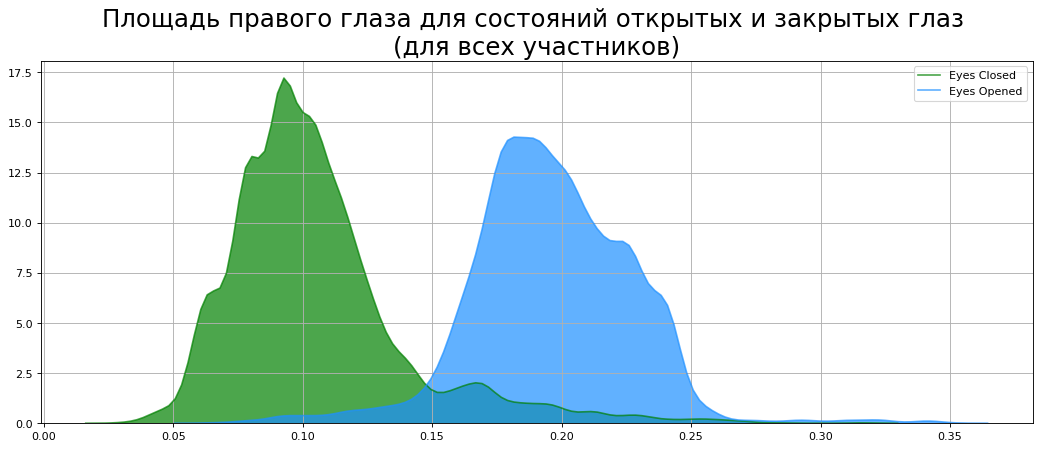

In [40]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

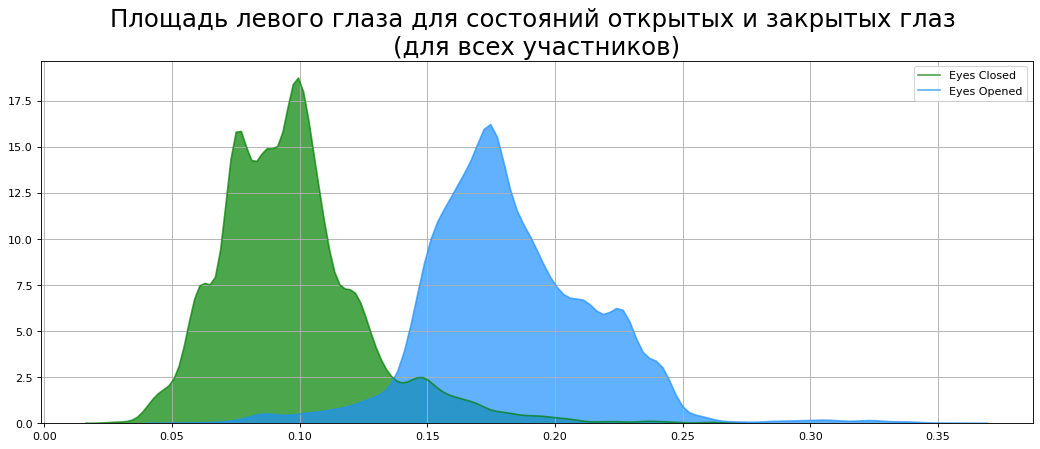

In [39]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_square'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_square'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Площадь левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

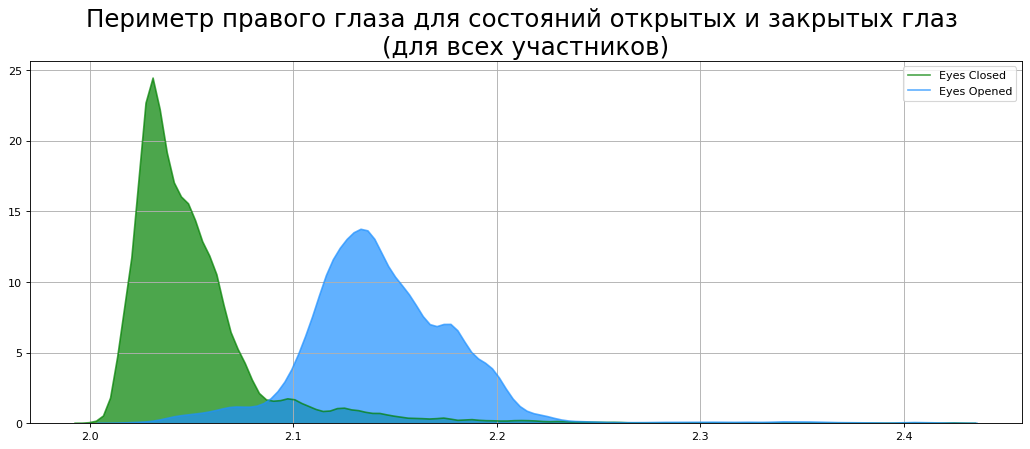

In [38]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_perimeter'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_perimeter'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Периметр правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

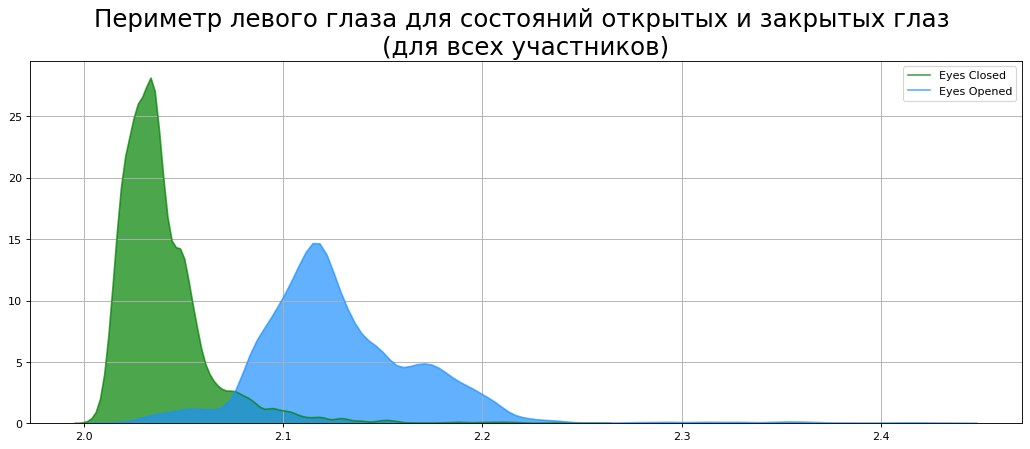

In [37]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_perimeter'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_perimeter'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Периметр левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

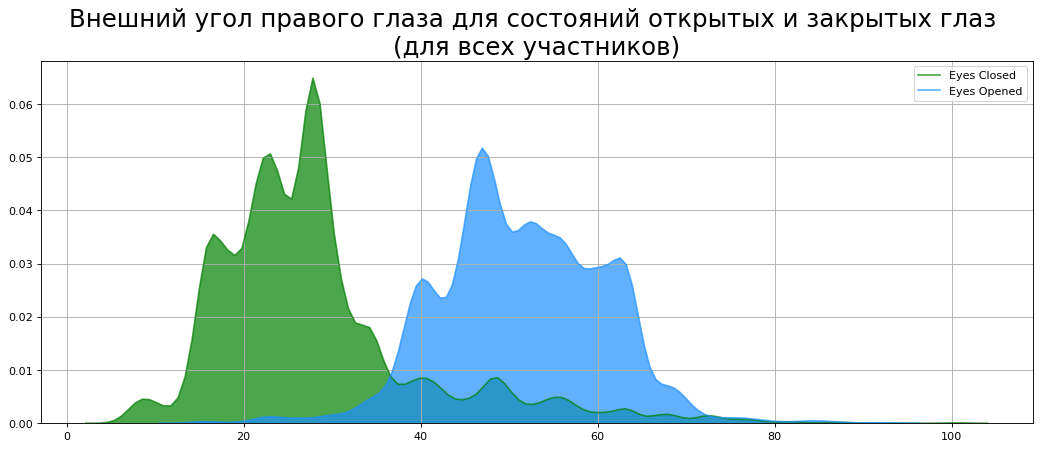

In [49]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_out_angle'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_out_angle'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внешний угол правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

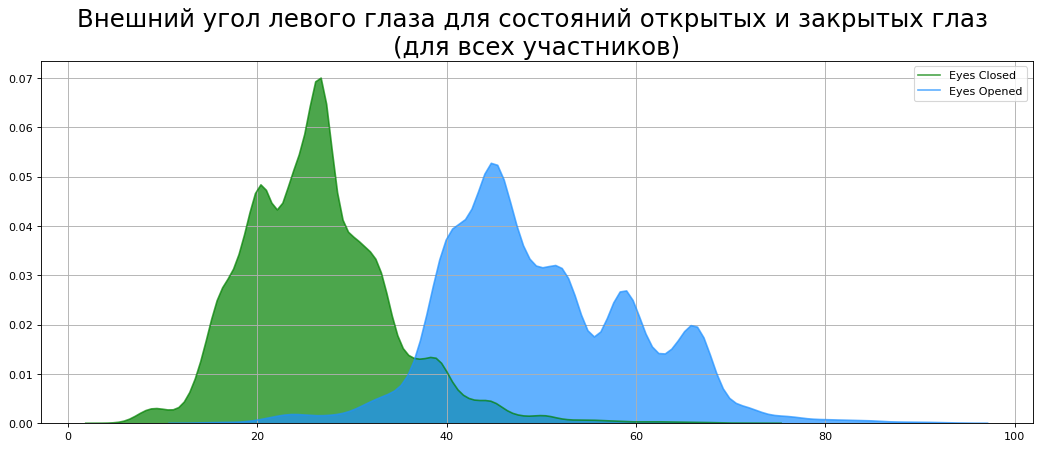

In [51]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_out_angle'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_out_angle'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внешний угол левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

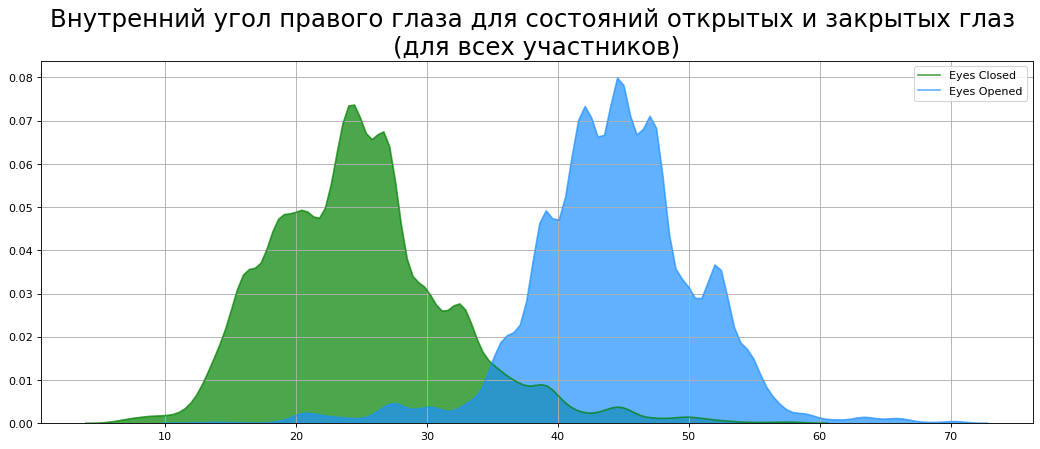

In [52]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_in_angle'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_in_angle'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внутренний угол правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

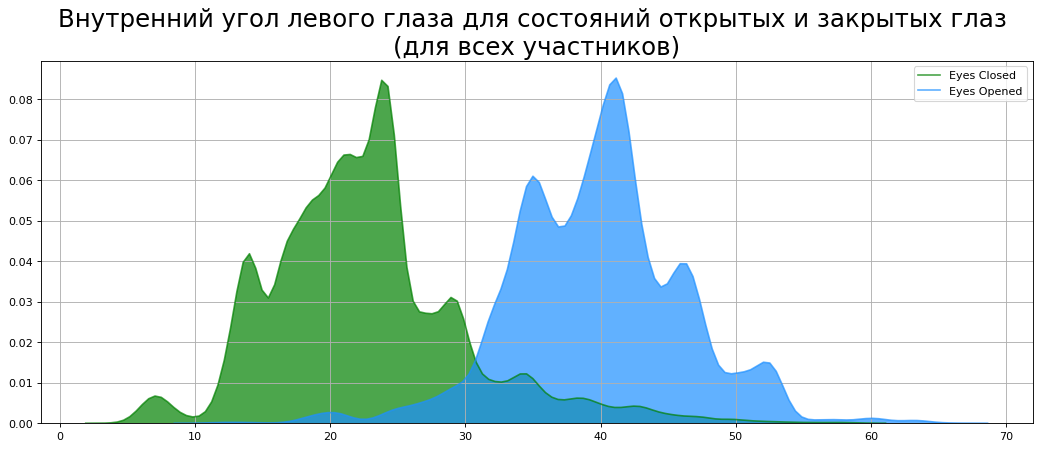

In [53]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_in_angle'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_in_angle'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внутренний угол левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

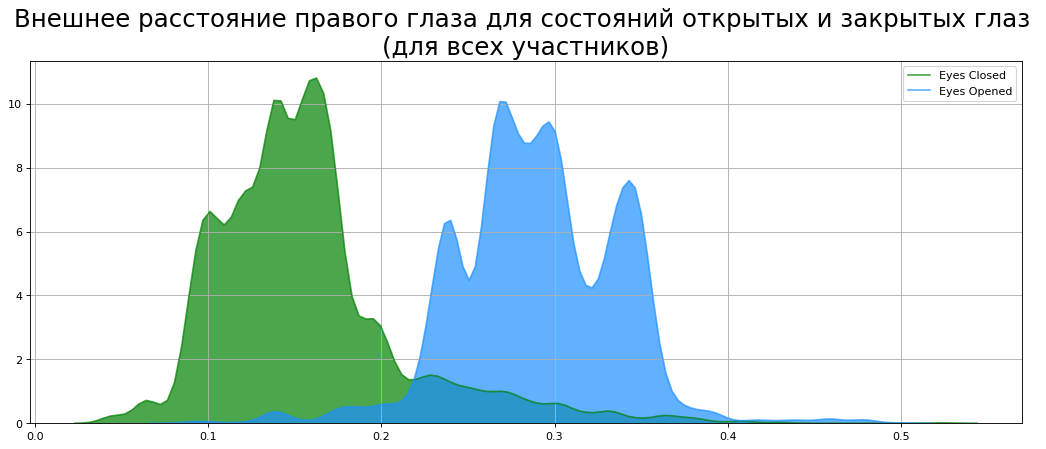

In [54]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_out_dist'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_out_dist'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внешнее расстояние правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

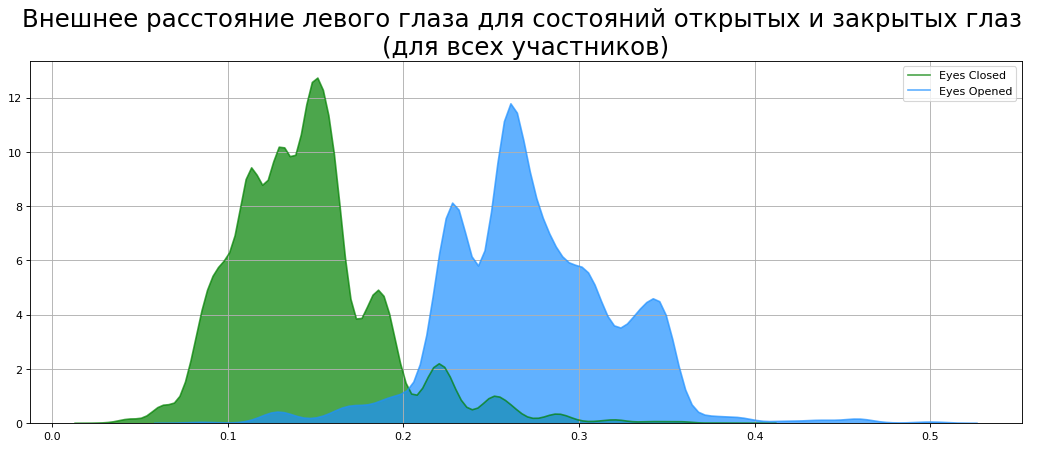

In [55]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_out_dist'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_out_dist'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внешнее расстояние левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

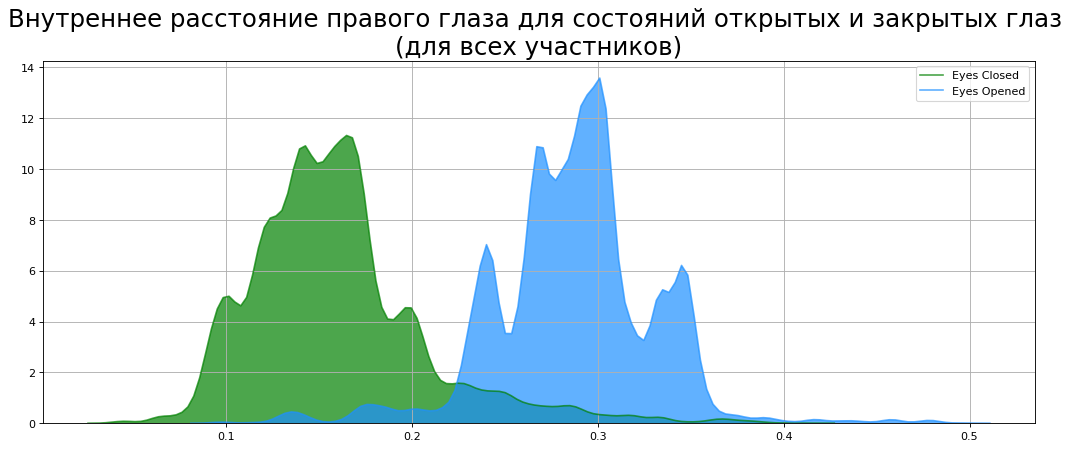

In [56]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'r_in_dist'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'r_in_dist'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внутреннее расстояние правого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

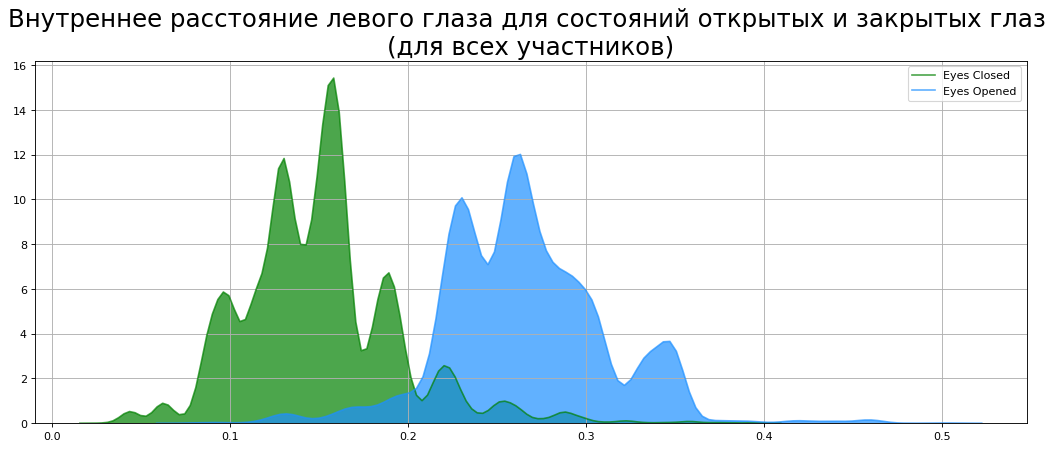

In [57]:
# Построение графика плотности
plt.figure(figsize=(16,6), dpi= 80)
sns.kdeplot(all_people.loc[all_people['state'] == 'closed', 'l_in_dist'],
            shade=True, color='g', label='Eyes Closed', alpha=0.7)
sns.kdeplot(all_people.loc[all_people['state'] == 'opened', 'l_in_dist'],
            shade=True, color='dodgerblue', label='Eyes Opened', alpha=0.7)
# Оформление построенного графика и вывод на экран
plt.title('Внутреннее расстояние левого глаза для состояний открытых и закрытых глаз \n(для всех участников)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

In [60]:
y = all_people['state']

In [61]:
x = all_people.iloc[:, 1:13]

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [63]:
%%time
# создаем модель "деревья решений"
# выбираем 100 деревьев в качестве параметра
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
model = RandomForestClassifier(n_estimators = 100)

# обучаем модель
model.fit(x_train, y_train)

Wall time: 1.81 s


RandomForestClassifier()

In [ ]:
import matplotlib as plt

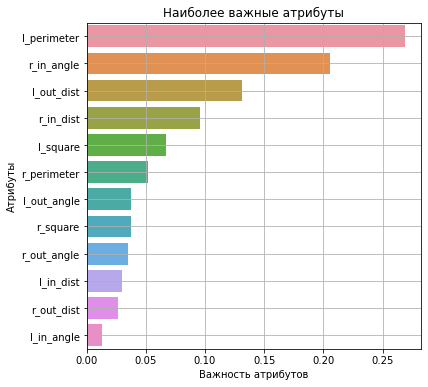

In [68]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.grid()
plt.show()

In [87]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred, digits = 4))

              precision    recall  f1-score   support

      closed     0.9803    0.9853    0.9828      1770
      opened     0.9851    0.9800    0.9825      1750

    accuracy                         0.9827      3520
   macro avg     0.9827    0.9827    0.9827      3520
weighted avg     0.9827    0.9827    0.9827      3520



In [73]:
reg_model = LogisticRegression(max_iter = 500)

In [74]:
# обучаем модель
reg_model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [80]:
y_test_hat = reg_model.predict(x_test)
y_test_hat_probs = reg_model.predict_proba(x_test)

In [83]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))

Confusion matrix:
 [[1662  108]
 [  78 1672]]


In [86]:
print(classification_report(y_test, y_test_hat, digits = 4))

              precision    recall  f1-score   support

      closed     0.9552    0.9390    0.9470      1770
      opened     0.9393    0.9554    0.9473      1750

    accuracy                         0.9472      3520
   macro avg     0.9472    0.9472    0.9472      3520
weighted avg     0.9473    0.9472    0.9472      3520



Логистическая регрессия позволяет достичь меньшего значения точности, чем модель "случайный лес", поэтому в итоговой программе будет использоваться модель "случайный лес". Данная модель будет сохранена с помощью библиотеки pickle.

In [ ]:
# Сохранение модели "случайный лес" с помощью библиотеки pickle
pickle.dump(model, open("D:/ML/Stepik/NN_CV/shape_random_forest.pkl", "wb"))

Классификация изображений на изображение лица человека и изображение атаки на биометрическое предъявление (фотография с фотографии)

In [88]:
# Подготовка новой выборки для обучения модели. Обозначения:
#   - Positive - фотография лица человека
#   - Negative - фотография с фотографии
positive_source_path = "D:/ML/Stepik/NN_CV/russian_dataset/all_images/Positive"
negative_source_path = "D:/ML/Stepik/NN_CV/russian_dataset/all_images/Negative"

# Получение всех имен файлов класса Positive и класса Negative
positive_file_names = os.listdir(positive_source_path)
negative_file_names = os.listdir(negative_source_path)

# В качестве детектора лица используется детектор библиотеки dlib
# predictor - модель для расстановки 68 контрольных точек на лице
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/ML/Stepik/NN_CV/models/shape_predictor_68_face_landmarks.dat")

positive_templates = []
negative_templates = []

# Обработка изображений класса Positive (фотография лица человека)
for file_name in positive_file_names:
    
    file_path = Path(positive_source_path, file_name)
    # Для загрузки изображения используется метод load_image_file библиотеки face_recognition
    img = face_recognition.load_image_file(file_path)
    # Преобразование изображения из цветового пространства BGR в цветовое пространство RGB
    img_in_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Обнаружение лица на изображении
    face_locations = face_recognition.face_locations(img_in_rgb)
    
    # Если на изображении найдено строго одно лицо, для этого лица формируется шаблон
    # и этот шаблон добавляется в массив
    if len(face_locations) == 1:
        template = face_recognition.face_encodings(img_in_rgb)[0]
        positive_templates.append(template)
        
    # Вывод текущего времени и имени обрабатываемого файла для отслеживания прогресса выполнения
    dt_now = datetime.datetime.now()
    current_time = dt_now.time()
    print("{0} - {1}".format(current_time, file_path))
    
# Преобразование массива шаблонов в массив numpy, а затем -- в dataframe
np_positive_templates = np.array(positive_templates)
positive_df = pd.DataFrame(np_positive_templates)

# Формирование меток класса Positive
positive_quantity = len(positive_templates)
positive_labels = ["face"] * positive_quantity
print("Positive templates processing is finished")
print("Positive templates quantity is: {0}".format(positive_quantity))

# Обработка изображений класса Neagative (фотография с фотографии)
for file_name in negative_file_names:
    
    file_path = Path(negative_source_path, file_name)
    # Для загрузки изображения используется метод load_image_file библиотеки face_recognition
    img = face_recognition.load_image_file(file_path)
    # Преобразование изображения из цветового пространства BGR в цветовое пространство RGB
    img_in_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Обнаружение лица на изображении
    face_locations = face_recognition.face_locations(img_in_rgb)
    
    # Если на изображении найдено строго одно лицо, для этого лица формируется шаблон
    # и этот шаблон добавляется в массив
    if len(face_locations) == 1:
        template = face_recognition.face_encodings(img_in_rgb)[0]
        negative_templates.append(template)
        
    # Вывод текущего времени и имени обрабатываемого файла для отслеживания прогресса выполнения
    dt_now = datetime.datetime.now()
    current_time = dt_now.time()
    print("{0} - {1}".format(current_time, file_path))
    
# Преобразование массива шаблонов в массив numpy, а затем -- в dataframe
np_negative_templates = np.array(negative_templates)
negative_df = pd.DataFrame(np_negative_templates)
negative_quantity = len(negative_templates)

# Формирование меток класса Positive
negative_labels = ["photo"] * negative_quantity
print("Negative templates processing is finished")
print("Negative templates quantity is: {0}".format(negative_quantity))

templates = pd.concat([positive_df, negative_df])
labels = positive_labels + negative_labels

15:42:16.263763 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0000.png
15:42:16.792352 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0001.png
15:42:17.327964 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0002.png
15:42:17.873464 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0003.png
15:42:18.415060 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0004.png
15:42:18.955256 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0005.png
15:42:19.500798 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0006.png
15:42:20.039356 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0007.png
15:42:20.574620 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0008.png
15:42:21.118169 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0009.png
15:42:21.652741 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0010.png
15:42:22.189688 - D:\

15:43:07.061440 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0093.png
15:43:07.604987 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0094.png
15:43:08.140557 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0095.png
15:43:08.675032 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0096.png
15:43:09.218619 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0097.png
15:43:09.756145 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0098.png
15:43:10.308667 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0099.png
15:43:10.853574 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0100.png
15:43:11.383161 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0101.png
15:43:11.927706 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0102.png
15:43:12.463284 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0103.png
15:43:13.002830 - D:\

15:43:58.018359 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0186.png
15:43:58.562683 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0187.png
15:43:59.112260 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0188.png
15:43:59.651775 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0189.png
15:44:00.205293 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0190.png
15:44:00.738257 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0191.png
15:44:01.298797 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0192.png
15:44:01.831374 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0193.png
15:44:02.385171 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0194.png
15:44:02.923457 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0195.png
15:44:03.519902 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0196.png
15:44:04.072469 - D:\

15:44:49.931716 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0279.png
15:44:50.476304 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0280.png
15:44:51.010779 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0281.png
15:44:51.544353 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0282.png
15:44:52.078107 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0283.png
15:44:52.629981 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0284.png
15:44:53.169330 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0285.png
15:44:53.702387 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0286.png
15:44:54.241657 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0287.png
15:44:54.771182 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0288.png
15:44:55.310378 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0289.png
15:44:55.854404 - D:\

15:45:42.595787 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0372.png
15:45:43.152300 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0373.png
15:45:43.697309 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0374.png
15:45:44.253932 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0375.png
15:45:44.809551 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0376.png
15:45:45.362827 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0377.png
15:45:45.899271 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0378.png
15:45:46.463323 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0379.png
15:45:47.020633 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0380.png
15:45:47.566418 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0381.png
15:45:48.149753 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_0382.png
15:45:48.703399 - D:\

15:46:30.287199 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0057.png
15:46:30.885306 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0058.png
15:46:31.459731 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0059.png
15:46:32.041176 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0060.png
15:46:32.721335 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0061.png
15:46:33.324986 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0062.png
15:46:33.911419 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0063.png
15:46:34.496191 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0064.png
15:46:35.058690 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0065.png
15:46:35.589421 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:47:18.834182 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0139.png
15:47:19.367710 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0140.png
15:47:19.903623 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0141.png
15:47:20.448166 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0142.png
15:47:20.985762 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0143.png
15:47:21.538247 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0144.png
15:47:22.080912 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0145.png
15:47:22.620000 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0146.png
15:47:23.146574 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0147.png
15:47:23.697156 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:48:03.647143 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0221.png
15:48:04.219700 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0222.png
15:48:04.820266 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0223.png
15:48:05.632095 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0224.png
15:48:06.405072 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0225.png
15:48:07.137071 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0226.png
15:48:07.920974 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0227.png
15:48:08.545307 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0228.png
15:48:09.176617 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0229.png
15:48:09.842835 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:48:58.556935 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0303.png
15:48:59.310879 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0304.png
15:48:59.973151 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0305.png
15:49:00.677266 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0306.png
15:49:01.300558 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0307.png
15:49:01.961791 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0308.png
15:49:02.583131 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0309.png
15:49:03.193063 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0310.png
15:49:03.742337 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0311.png
15:49:04.318796 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:49:45.018800 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0385.png
15:49:45.635163 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0386.png
15:49:46.285415 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0387.png
15:49:46.962606 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0388.png
15:49:47.615856 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0389.png
15:49:48.367847 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0390.png
15:49:49.033068 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0391.png
15:49:49.681334 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0392.png
15:49:50.294694 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0393.png
15:49:50.922019 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:50:35.001964 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0467.png
15:50:35.536543 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0468.png
15:50:36.076360 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0469.png
15:50:36.620971 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0470.png
15:50:37.166513 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0471.png
15:50:37.692702 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0472.png
15:50:38.233904 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0473.png
15:50:38.769499 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0474.png
15:50:39.320029 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0475.png
15:50:39.857592 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:51:20.081565 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0549.png
15:51:20.688354 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0550.png
15:51:21.288956 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0551.png
15:51:21.877084 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0552.png
15:51:22.448609 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0553.png
15:51:23.056982 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0554.png
15:51:23.694422 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0555.png
15:51:24.280074 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0556.png
15:51:24.907971 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0557.png
15:51:25.464404 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:52:06.646066 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0631.png
15:52:07.193292 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0632.png
15:52:07.720979 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0633.png
15:52:08.255835 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0634.png
15:52:08.789465 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0635.png
15:52:09.348556 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0636.png
15:52:09.901144 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0637.png
15:52:10.448618 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0638.png
15:52:10.984313 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0639.png
15:52:11.526865 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:52:52.599493 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0713.png
15:52:53.143427 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0714.png
15:52:53.703934 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0715.png
15:52:54.304327 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0716.png
15:52:54.880825 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0717.png
15:52:55.428257 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0718.png
15:52:55.965823 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0719.png
15:52:56.509413 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0720.png
15:52:57.053913 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0721.png
15:52:57.590479 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:53:38.524187 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0795.png
15:53:39.091629 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0796.png
15:53:39.643492 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0797.png
15:53:40.209989 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0798.png
15:53:40.753524 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0799.png
15:53:41.291802 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0800.png
15:53:41.828370 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0801.png
15:53:42.378388 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0802.png
15:53:42.942087 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0803.png
15:53:43.517251 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:54:25.086156 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0877.png
15:54:25.788279 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0878.png
15:54:26.450508 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0879.png
15:54:27.101768 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0880.png
15:54:27.665260 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0881.png
15:54:28.233137 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0882.png
15:54:28.768996 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0883.png
15:54:29.308645 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0884.png
15:54:29.844266 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0885.png
15:54:30.388778 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:55:08.394708 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0959.png
15:55:08.973163 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0960.png
15:55:09.607466 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0961.png
15:55:10.240813 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0962.png
15:55:10.895024 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0963.png
15:55:11.563494 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0964.png
15:55:12.474060 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0965.png
15:55:13.144269 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0966.png
15:55:13.750649 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new_0967.png
15:55:14.373982 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\andrew_kitchen_new

15:56:00.541273 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0005.jpg
15:56:01.161115 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0006.jpg
15:56:01.793380 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0007.jpg
15:56:02.430910 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0008.jpg
15:56:03.031303 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0009.jpg
15:56:03.641031 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0010.jpg
15:56:04.267556 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0011.jpg
15:56:04.887897 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0012.jpg
15:56:05.516754 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0013.jpg
15:56:06.126047 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\bilal_small_0014.jpg
15:56:06.723264 - D:\ML\Stepik\NN_CV\russian_dataset\all_ima

15:56:57.973692 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0013.jpg
15:56:58.621080 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0014.jpg
15:56:59.299111 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0015.jpg
15:56:59.952405 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0016.jpg
15:57:00.618683 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0017.jpg
15:57:01.293010 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0018.jpg
15:57:02.025094 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0019.jpg
15:57:02.695466 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0020.jpg
15:57:03.338705 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0021.jpg
15:57:03.958008 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\boiko_small_0022.jpg
15:57:04.577518 - D:\ML\Stepik\NN_CV\russian_dataset\all_ima

15:58:19.178460 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_03.jpg
15:58:20.480567 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_04.jpg
15:58:21.865540 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_05.jpg
15:58:23.290000 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_06.jpg
15:58:24.594515 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_07.jpg
15:58:25.923099 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_08.jpg
15:58:27.328391 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_09.jpg
15:58:28.745066 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_10.jpg
15:58:30.085514 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_11.jpg
15:58:31.506028 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_12.jpg
15:58:32.930747 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3_13.jpg
15:58:34.325393 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD3

16:00:00.308878 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD7_17.jpg
16:00:01.028854 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD7_18.jpg
16:00:01.683005 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD7_19.jpg
16:00:02.340280 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD7_20.jpg
16:00:02.992382 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8.jpg
16:00:03.649507 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_01.jpg
16:00:04.288134 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_02.jpg
16:00:04.896793 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_03.jpg
16:00:05.566006 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_04.jpg
16:00:06.184012 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_05.jpg
16:00:06.800368 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_06.jpg
16:00:07.461594 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\FD8_07

16:01:03.121871 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0006.jpg
16:01:03.744207 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0007.jpg
16:01:04.391479 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0008.jpg
16:01:04.977909 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0009.jpg
16:01:05.565019 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0010.jpg
16:01:06.153449 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0011.jpg
16:01:06.735707 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0012.jpg
16:01:07.315205 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0013.jpg
16:01:07.893625 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0014.jpg
16:01:08.497140 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\kolganov_medium_0015.jpg
16:01:09.083368 - D:

16:01:53.069301 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0009.png
16:01:53.612614 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0010.png
16:01:54.150787 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0011.png
16:01:54.687356 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0012.png
16:01:55.225812 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0013.png
16:01:55.764210 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0014.png
16:01:56.302757 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0015.png
16:01:56.844307 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0016.png
16:01:57.383904 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0017.png
16:01:57.923420 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:02:37.417912 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0090.png
16:02:37.938520 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0091.png
16:02:38.653608 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0092.png
16:02:39.205492 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0093.png
16:02:39.756981 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0094.png
16:02:40.295539 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0095.png
16:02:40.812690 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0096.png
16:02:41.348263 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0097.png
16:02:41.907767 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0098.png
16:02:42.440564 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:03:21.652253 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0171.png
16:03:22.193807 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0172.png
16:03:22.733413 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0173.png
16:03:23.259693 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0174.png
16:03:23.802293 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0175.png
16:03:24.345793 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0176.png
16:03:24.888343 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0177.png
16:03:25.428896 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0178.png
16:03:25.967500 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0179.png
16:03:26.498515 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:04:01.174481 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0254.png
16:04:01.195778 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0255.png
16:04:01.217584 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0256.png
16:04:01.239902 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0257.png
16:04:01.265789 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0258.png
16:04:01.289727 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0259.png
16:04:01.312242 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0260.png
16:04:01.334228 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0261.png
16:04:01.357162 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0263.png
16:04:01.382095 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:04:32.152141 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0367.png
16:04:32.677866 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0368.png
16:04:32.699811 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0369.png
16:04:32.722146 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0370.png
16:04:32.743421 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0371.png
16:04:32.765300 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0372.png
16:04:32.788373 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0373.png
16:04:32.809995 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0374.png
16:04:33.337514 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0376.png
16:04:33.359638 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:05:09.301004 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0496.png
16:05:09.814731 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0497.png
16:05:10.354291 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0498.png
16:05:10.879886 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0499.png
16:05:11.404483 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0500.png
16:05:11.931075 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0501.png
16:05:12.453194 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0502.png
16:05:13.029450 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0503.png
16:05:13.568969 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0504.png
16:05:14.263110 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:05:52.184102 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0577.png
16:05:52.726661 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0578.png
16:05:53.265262 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0579.png
16:05:53.807764 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0580.png
16:05:54.339342 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0581.png
16:05:54.876906 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0582.png
16:05:55.400549 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0583.png
16:05:55.939105 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0584.png
16:05:56.463662 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0585.png
16:05:56.986958 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:06:34.733667 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0658.png
16:06:35.258548 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0659.png
16:06:35.809986 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0660.png
16:06:36.328435 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0661.png
16:06:36.854032 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0662.png
16:06:37.368213 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0663.png
16:06:37.892818 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0664.png
16:06:38.418407 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0665.png
16:06:38.952978 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0666.png
16:06:39.476594 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:07:18.064504 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0739.png
16:07:18.590096 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0740.png
16:07:19.122440 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0741.png
16:07:19.648081 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0742.png
16:07:20.178619 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0743.png
16:07:20.704215 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0744.png
16:07:21.238784 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0745.png
16:07:21.766374 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0746.png
16:07:22.308924 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0747.png
16:07:22.832523 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:08:02.574036 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0820.png
16:08:03.214323 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0821.png
16:08:03.749892 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0822.png
16:08:04.283510 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0823.png
16:08:04.812052 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0824.png
16:08:05.336620 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0825.png
16:08:05.849905 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0826.png
16:08:06.378335 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0827.png
16:08:06.908746 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0828.png
16:08:07.438329 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:08:45.740908 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0901.png
16:08:46.268637 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0902.png
16:08:46.789234 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0903.png
16:08:47.306217 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0904.png
16:08:47.836802 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0905.png
16:08:48.410322 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0906.png
16:08:48.936904 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0907.png
16:08:49.461456 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0908.png
16:08:49.972983 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0909.png
16:08:50.500895 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:09:28.330177 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0982.png
16:09:28.856772 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0983.png
16:09:29.359203 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0984.png
16:09:29.871833 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0985.png
16:09:30.389450 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0986.png
16:09:30.902084 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0987.png
16:09:31.413710 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0988.png
16:09:31.927644 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0989.png
16:09:32.446581 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_0990.png
16:09:32.961219 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:10:10.749453 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1063.png
16:10:11.276070 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1064.png
16:10:11.802643 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1065.png
16:10:12.316945 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1066.png
16:10:12.851556 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1067.png
16:10:13.375118 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1068.png
16:10:13.903705 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1069.png
16:10:14.409986 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1070.png
16:10:14.923504 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_kitchen_new_1071.png
16:10:15.452094 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Positive\tatjana_k

16:10:54.770535 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0067.png
16:10:55.294182 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0068.png
16:10:55.825713 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0069.png
16:10:56.348317 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0070.png
16:10:56.872958 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0071.png
16:10:57.394519 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0072.png
16:10:57.935073 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0073.png
16:10:58.546438 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0074.png
16:10:59.287458 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0075.png
16:10:59.970631 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0076.png
16:11:00.634856 - D:\ML\Stepik\NN_CV\rus

16:11:40.893519 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0153.png
16:11:41.405259 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0154.png
16:11:41.922877 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0155.png
16:11:42.433437 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0156.png
16:11:42.958075 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0157.png
16:11:43.495599 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0158.png
16:11:44.030214 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0159.png
16:11:44.555765 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0160.png
16:11:45.079757 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0161.png
16:11:45.604402 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0162.png
16:11:46.124444 - D:\ML\Stepik\NN_CV\rus

16:12:26.214884 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0239.png
16:12:26.737489 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0240.png
16:12:27.270110 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0241.png
16:12:27.793112 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0242.png
16:12:28.336662 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0243.png
16:12:28.882039 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0244.png
16:12:29.426539 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0245.png
16:12:29.963127 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0246.png
16:12:30.505652 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0247.png
16:12:31.033830 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0248.png
16:12:31.575179 - D:\ML\Stepik\NN_CV\rus

16:13:12.181175 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0325.png
16:13:12.710762 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0326.png
16:13:13.237354 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0327.png
16:13:13.751522 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0328.png
16:13:14.284102 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0329.png
16:13:14.809696 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0330.png
16:13:15.353639 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0331.png
16:13:15.870203 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0332.png
16:13:16.395797 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0333.png
16:13:16.923386 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_fake_0334.png
16:13:17.439948 - D:\ML\Stepik\NN_CV\rus

16:13:57.630847 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0010.png
16:13:58.176121 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0011.png
16:13:58.721353 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0012.png
16:13:59.246301 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0013.png
16:13:59.779714 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0014.png
16:14:00.321273 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0015.png
16:14:00.847171 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0016.png
16:14:01.393223 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0017.png
16:14:01.918384 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0018.png
16:14:02.451040 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:14:39.700445 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0090.png
16:14:40.216249 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0091.png
16:14:40.740848 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0092.png
16:14:41.252497 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0093.png
16:14:41.781088 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0094.png
16:14:42.293925 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0095.png
16:14:42.817714 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0096.png
16:14:43.369779 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0097.png
16:14:43.906331 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0098.png
16:14:44.419742 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:15:21.064861 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0170.png
16:15:21.579473 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0171.png
16:15:22.102094 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0172.png
16:15:22.629715 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0173.png
16:15:23.148331 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0174.png
16:15:23.663962 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0175.png
16:15:24.178577 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0176.png
16:15:24.710656 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0177.png
16:15:25.234030 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_1_0178.png
16:15:25.750648 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:16:02.790943 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0000.png
16:16:03.360572 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0001.png
16:16:03.932197 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0002.png
16:16:04.492575 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0003.png
16:16:05.051339 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0004.png
16:16:05.627845 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0005.png
16:16:06.171200 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0006.png
16:16:06.744670 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0007.png
16:16:07.290781 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0008.png
16:16:07.838972 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:16:47.905943 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0080.png
16:16:48.450897 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0081.png
16:16:48.993449 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0082.png
16:16:49.534060 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0083.png
16:16:50.080543 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0084.png
16:16:50.608538 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0085.png
16:16:51.149096 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0086.png
16:16:51.689650 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0087.png
16:16:52.229808 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0088.png
16:16:52.758925 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:17:32.478454 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0160.png
16:17:33.062675 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0161.png
16:17:33.632783 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0162.png
16:17:34.196200 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0163.png
16:17:34.775940 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0164.png
16:17:35.325305 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0165.png
16:17:35.895987 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0166.png
16:17:36.457766 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0167.png
16:17:37.007021 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0168.png
16:17:37.554891 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:18:18.199953 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0240.png
16:18:18.761488 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0241.png
16:18:19.340046 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0242.png
16:18:19.906611 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0243.png
16:18:20.485721 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0244.png
16:18:21.065921 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0245.png
16:18:21.652159 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0246.png
16:18:22.220653 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0247.png
16:18:22.769745 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_2_0248.png
16:18:23.330262 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:19:03.693857 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0070.png
16:19:04.271954 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0071.png
16:19:04.860383 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0072.png
16:19:05.464769 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0073.png
16:19:06.165892 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0074.png
16:19:06.816197 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0075.png
16:19:07.404961 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0076.png
16:19:07.981486 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0077.png
16:19:08.571910 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0078.png
16:19:09.167318 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:19:49.630421 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0150.png
16:19:50.209211 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0151.png
16:19:50.797641 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0152.png
16:19:51.398085 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0153.png
16:19:51.998430 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0154.png
16:19:52.574614 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0155.png
16:19:53.170030 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0156.png
16:19:53.742985 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0157.png
16:19:54.320320 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0158.png
16:19:54.908297 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:20:36.149218 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0230.png
16:20:36.734283 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0231.png
16:20:37.315910 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0232.png
16:20:37.909339 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0233.png
16:20:38.483496 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0234.png
16:20:39.129332 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0235.png
16:20:39.824475 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0236.png
16:20:40.454792 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0237.png
16:20:41.041305 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_3_0238.png
16:20:41.636988 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:21:24.646466 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0060.png
16:21:25.238894 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0061.png
16:21:25.851420 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0062.png
16:21:26.461231 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0063.png
16:21:27.052589 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0064.png
16:21:27.659711 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0065.png
16:21:28.264194 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0066.png
16:21:28.852226 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0067.png
16:21:29.465870 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0068.png
16:21:30.073735 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:22:12.381397 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0140.png
16:22:12.953904 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0141.png
16:22:13.559329 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0142.png
16:22:14.151114 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0143.png
16:22:14.750473 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0144.png
16:22:15.337582 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0145.png
16:22:15.931719 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0146.png
16:22:16.526499 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0147.png
16:22:17.142251 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0148.png
16:22:17.755950 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:23:00.199001 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0220.png
16:23:00.788238 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0221.png
16:23:01.368696 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0222.png
16:23:01.959117 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0223.png
16:23:02.539565 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0224.png
16:23:03.122007 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0225.png
16:23:03.713427 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0226.png
16:23:04.296866 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0227.png
16:23:04.879657 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\anatolij_photo_new_4_0228.png
16:23:05.491026 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\

16:23:44.687998 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0052.png
16:23:45.213641 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0053.png
16:23:45.728349 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0054.png
16:23:46.248329 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0055.png
16:23:46.768383 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0056.png
16:23:47.288145 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0057.png
16:23:47.806762 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0058.png
16:23:48.440070 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0059.png
16:23:48.982678 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0060.png
16:23:49.531177 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0061.png
16:23:50.0

16:24:28.749547 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0135.png
16:24:29.313992 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0136.png
16:24:29.833711 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0137.png
16:24:30.388232 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0138.png
16:24:30.900650 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0139.png
16:24:31.417273 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0140.png
16:24:31.931700 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0141.png
16:24:32.452364 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0142.png
16:24:32.976692 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0143.png
16:24:33.510307 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0144.png
16:24:34.0

16:25:12.272323 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0218.png
16:25:12.793858 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0219.png
16:25:13.311405 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0220.png
16:25:13.831951 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0221.png
16:25:14.344532 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0222.png
16:25:14.872064 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0223.png
16:25:15.392676 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0224.png
16:25:15.908442 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0225.png
16:25:16.422093 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0226.png
16:25:16.948689 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\andrew_photo_new_0227.png
16:25:17.4

16:28:32.420913 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake4_11.jpg
16:28:36.177772 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake4_12.jpg
16:28:39.887701 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake4_13.jpg
16:28:43.607716 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake4_14.jpg
16:28:47.331205 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake4_18.jpg
16:28:51.105808 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5.jpg
16:28:54.800027 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5_01.jpg
16:28:58.706072 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5_02.jpg
16:29:02.439091 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5_03.jpg
16:29:06.145841 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5_04.jpg
16:29:09.846531 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\Fake5_05.jpg
16:29:13.594077 - D:\ML\Stepik\NN_CV\russian_dataset\all_

16:32:57.724658 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0026.png
16:32:58.322979 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0027.png
16:32:58.903426 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0028.png
16:32:59.494846 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0029.png
16:33:00.073871 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0030.png
16:33:00.662300 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0031.png
16:33:01.248784 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0032.png
16:33:01.837109 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0033.png
16:33:02.413864 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0034.png
16:33:02.992351 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0035.png
16:33:03.6

16:33:46.069963 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0109.png
16:33:46.650595 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0110.png
16:33:47.231160 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0111.png
16:33:47.826571 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0112.png
16:33:48.545156 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0113.png
16:33:49.139059 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0114.png
16:33:49.737226 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0115.png
16:33:50.321663 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0116.png
16:33:50.909141 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0117.png
16:33:51.501065 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0118.png
16:33:52.0

16:34:34.670626 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0192.png
16:34:35.250521 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0193.png
16:34:35.829632 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0194.png
16:34:36.407043 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0195.png
16:34:36.984157 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0196.png
16:34:37.559666 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0197.png
16:34:38.134085 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0198.png
16:34:38.718446 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0199.png
16:34:39.299418 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0200.png
16:34:39.873992 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\julija_photo_new_0201.png
16:34:40.4

16:35:29.620443 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0025.jpg
16:35:30.482140 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0026.jpg
16:35:31.340892 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0027.jpg
16:35:32.197553 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0028.jpg
16:35:33.054264 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0029.jpg
16:35:33.917254 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0030.jpg
16:35:34.781890 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0031.jpg
16:35:35.647760 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0032.jpg
16:35:36.521487 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kablucheva_fake_large_0033.jpg
16:35:37.388644 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\

16:36:33.459792 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0025.jpg
16:36:34.487007 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0026.jpg
16:36:35.552576 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0027.jpg
16:36:36.574387 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0028.jpg
16:36:37.618122 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0029.jpg
16:36:38.655346 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0030.jpg
16:36:39.688137 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0031.jpg
16:36:40.714548 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0032.jpg
16:36:41.755243 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_fake_large_0033.jpg
16:36:42.785073 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\kolganov_

16:37:38.954236 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0026.jpg
16:37:39.707933 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0027.jpg
16:37:40.468191 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0028.jpg
16:37:41.219714 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0029.jpg
16:37:41.975609 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0030.jpg
16:37:42.720361 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0031.jpg
16:37:43.471417 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0032.jpg
16:37:44.255133 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0033.jpg
16:37:45.028065 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0034.jpg
16:37:45.790027 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_fake_large_0035.jpg


16:38:28.085613 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0027.png
16:38:28.622132 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0028.png
16:38:29.149784 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0029.png
16:38:29.680368 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0030.png
16:38:30.217931 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0031.png
16:38:30.757870 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0032.png
16:38:31.303834 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0033.png
16:38:31.841447 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0034.png
16:38:32.380665 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0035.png
16:38:32.912247 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1

16:39:12.083095 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0109.png
16:39:12.607672 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0110.png
16:39:13.137511 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0111.png
16:39:13.670113 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0112.png
16:39:14.201715 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0113.png
16:39:14.741224 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0114.png
16:39:15.274796 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0115.png
16:39:15.812064 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0116.png
16:39:16.351132 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0117.png
16:39:16.884670 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1

16:39:55.940648 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0191.png
16:39:56.476002 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0192.png
16:39:57.019554 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0193.png
16:39:57.551900 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0194.png
16:39:58.088468 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0195.png
16:39:58.636004 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0196.png
16:39:59.163530 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0197.png
16:39:59.696347 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0198.png
16:40:00.225533 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1_0199.png
16:40:00.761121 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_1

16:40:39.722174 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0023.png
16:40:40.253419 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0024.png
16:40:40.765571 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0025.png
16:40:41.286199 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0026.png
16:40:41.829740 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0027.png
16:40:42.341668 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0028.png
16:40:42.860753 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0029.png
16:40:43.395472 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0030.png
16:40:43.937024 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0031.png
16:40:44.496447 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2

16:41:23.484796 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0105.png
16:41:24.016154 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0106.png
16:41:24.547758 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0107.png
16:41:25.079816 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0108.png
16:41:25.619498 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0109.png
16:41:26.144371 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0110.png
16:41:26.678969 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0111.png
16:41:27.215971 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0112.png
16:41:27.739590 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0113.png
16:41:28.267162 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2

16:42:07.144442 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0187.png
16:42:07.697990 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0188.png
16:42:08.231228 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0189.png
16:42:08.758821 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0190.png
16:42:09.287408 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0191.png
16:42:09.825068 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0192.png
16:42:10.351578 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0193.png
16:42:10.882170 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0194.png
16:42:11.408761 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2_0195.png
16:42:11.940894 - D:\ML\Stepik\NN_CV\russian_dataset\all_images\Negative\random_photo_new_2

In [89]:
templates.shape

(5600, 128)

In [91]:
len(labels)

5600

In [93]:
photos_textures = templates.assign(labels = labels)

In [94]:
photos_textures.shape

(5600, 129)

In [95]:
# Сохранение набора данных в файл формата .csv для последующего использования
# без необходимости повторной обработки большого количества изображений
photos_textures.to_csv('D:/ML/Stepik/NN_CV/russian_dataset/all_images/photos_textures.csv', index=False)

In [99]:
# Обучение классификатора "случайный лес" без масштабирования и использования метода главных компонент
X = templates
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [100]:
%%time
# Выбор количества деревьев, равного 100 ...
model = RandomForestClassifier(n_estimators = 100)

# ... и обучение модели
model.fit(X_train,y_train)

Wall time: 2.33 s


RandomForestClassifier()

In [102]:
# Оценка модели
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred, digits = 4))

model.score(X_test, y_test)

              precision    recall  f1-score   support

        face     0.9868    1.0000    0.9934       822
       photo     1.0000    0.9872    0.9935       858

    accuracy                         0.9935      1680
   macro avg     0.9934    0.9936    0.9935      1680
weighted avg     0.9935    0.9935    0.9935      1680



0.993452380952381

In [103]:
# Матрица несоответствия
print('Confusion matrix:\n', confusion_matrix(y_test, model_pred))

Confusion matrix:
 [[822   0]
 [ 11 847]]


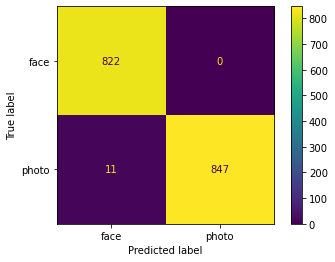

In [105]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

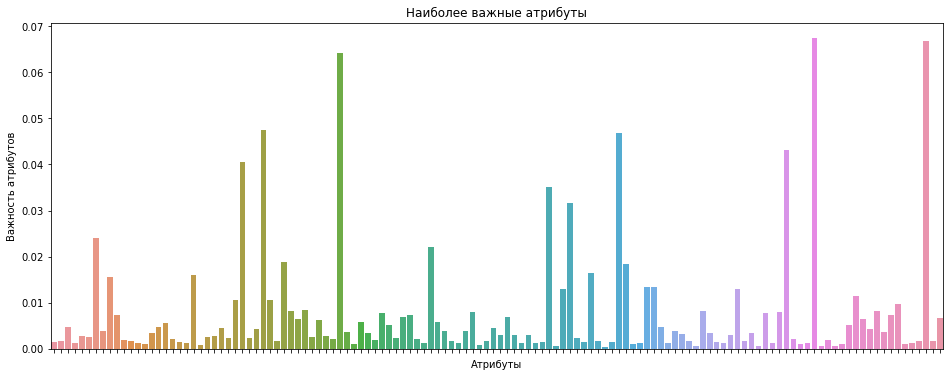

In [104]:
# Оценка количества наиболее важных атрибутов
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x=feature_imp.index, y=feature_imp)

ax.set(xticklabels = [])

plt.xlabel('Атрибуты')
plt.ylabel('Важность атрибутов')
plt.title("Наиболее важные атрибуты")
plt.show()

In [106]:
# Сохранение модели "случайный лес" без масштабирования и использования метода главных компонент
pickle.dump(model, open("D:/ML/Stepik/NN_CV/models/texture_random_forest.pkl", "wb"))

In [107]:
# Обучение классификатора "случайный лес" с масштабированием и использованием метода главных компонент
X = templates
y = labels

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

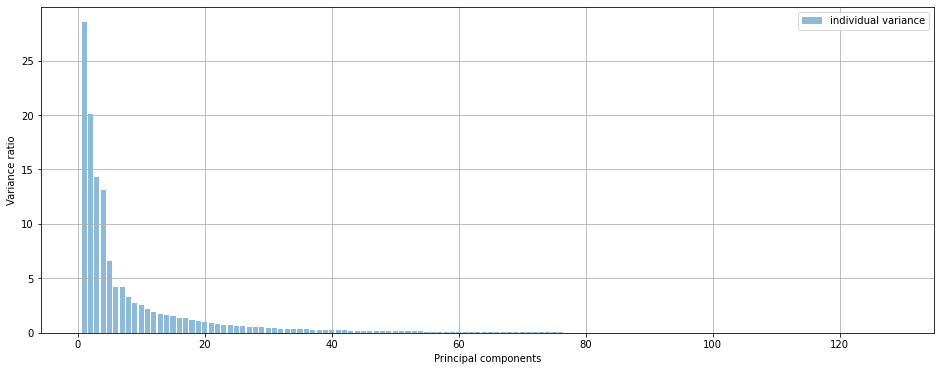

In [108]:
# Визуализация
pca = PCA()
pca.fit_transform(X_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(16, 6))
plt.bar(range(1,(len(pca_variance)+1)), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.grid()
plt.show()

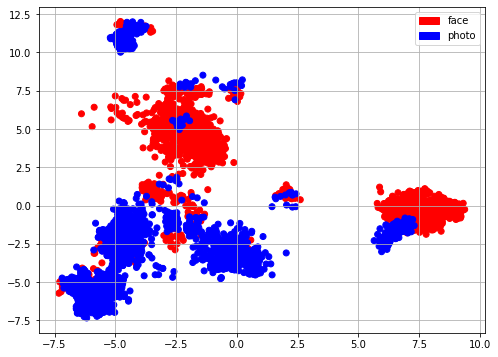

In [109]:
# Обучение модели с использованием 20 главных компонент
pca20 = PCA(n_components = 20)
pca20.fit(X_scaled)
x_3d = pca20.transform(X_scaled)

colors = {'face':'red', 'photo':'blue'}

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c = pd.Series(labels).map(colors))

face_legend = mpatches.Patch(color='red', label='face')
photo_legend = mpatches.Patch(color='blue', label='photo')
plt.legend(handles=[face_legend, photo_legend])

plt.grid()
plt.show()

In [111]:
# Тестирование работы классификатора "случайный лес" на наборе данных сокращенной размерности
X_train, X_test, y_train, y_test = train_test_split(x_3d, y, test_size = 0.3)

model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train,y_train)

model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred, digits = 4))
model.score(X_test, y_test)

              precision    recall  f1-score   support

        face     0.9954    1.0000    0.9977       874
       photo     1.0000    0.9950    0.9975       806

    accuracy                         0.9976      1680
   macro avg     0.9977    0.9975    0.9976      1680
weighted avg     0.9976    0.9976    0.9976      1680



0.9976190476190476

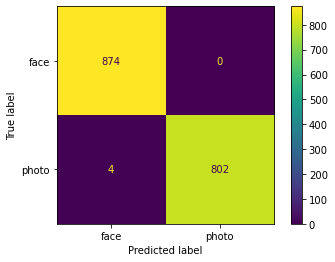

In [112]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [ ]:
Качество работы модели стало выше, неверно классифицированных изображений осталось всего 4

In [113]:
# Сохранение модели метода главных компонент
pickle.dump(pca20, open("D:/ML/Stepik/NN_CV/models/texture_pca20.pkl", "wb"))

In [114]:
# Сохранение модели "случайный лес" с масштабированием и использованием метода главных компонент
pickle.dump(model, open("D:/ML/Stepik/NN_CV/models/texture_pca20_random_forest.pkl", "wb"))

In [115]:
# Пример использования модели
one_prediction = model.predict(X_test[219].reshape(1, -1))
one_prediction[0]

'face'

In [116]:
# Обучение модели логистической регрессии
reg_model = LogisticRegression(max_iter = 500)
reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [118]:
model_pred = reg_model.predict(X_test)
print(classification_report(y_test, model_pred, digits = 4))
reg_model.score(X_test, y_test)

              precision    recall  f1-score   support

        face     0.9839    0.9817    0.9828       874
       photo     0.9802    0.9826    0.9814       806

    accuracy                         0.9821      1680
   macro avg     0.9821    0.9822    0.9821      1680
weighted avg     0.9821    0.9821    0.9821      1680



0.9821428571428571

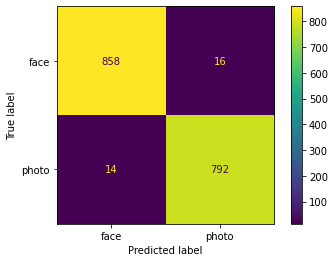

In [119]:
plot_confusion_matrix(reg_model, X_test, y_test)  
plt.show()

С использованием логистической регрессии качество модели стало хуже

In [ ]:
# Вспомогательная функция для обработки всех изображений в заданной папке
# и подготовки их для использования при обучении нейронной сети.
# Подготовка заключается в кадрировании ("обрезке") изображений так,
# чтобы они содержали только лицо

# Prepare new training dataset to learn neural network
source_path = "D:/ML/Stepik/NN_CV/russian_dataset/new_images/andrew_kitchen_new"
destination_path = "D:/ML/Stepik/NN_CV/russian_dataset/new_images/kitchen_good_result"
file_names = os.listdir(source_path)

# Максимальное количество изображений, которое следует использовать из каждой папки
img_quantity = 1000
img_counter = 0

prefix = "andrew_kitchen_new_"

detector = dlib.get_frontal_face_detector()

for file_name in file_names:
    dt_now = datetime.datetime.now()
    current_time = dt_now.time()
    
    file_path = Path(source_path, file_name)
    name_parts = file_name.split("_")
    new_file_name = "".join([prefix, name_parts[1]])
    
    print("{0} - {1}".format(current_time, file_path))
    
    img = face_recognition.load_image_file(file_path)
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    faces = detector(frame)
    
    if len(faces) == 1:
        face = faces[0]
        
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        
        face_width = x2 - x1
        face_height = y2 - y1
        
        square_side = np.max([face_width, face_height]) * 1.2
        
        landmarks = predictor(frame, face)
        
        nose = landmarks.part(33)
        
        x1_corr = nose.x - int(square_side / 2)
        x2_corr = nose.x + int(square_side / 2)
        y1_corr = nose.y - int(square_side / 2)
        y2_corr = nose.y + int(square_side / 2)
        
        cropped_frame = frame[y1:y2, x1:x2]
                
        dt_now = datetime.datetime.now()
        current_time = dt_now.time()
        
        new_file_path = Path(destination_path, new_file_name)
        new_file_path = str(new_file_path)
        
        print("{0} - {1}".format(current_time, new_file_path))
        
        cv2.imwrite(new_file_path, cropped_frame)
        
        img_counter += 1
        if img_counter >= img_quantity:
            break
        

In [ ]:
# Вспомогательная функция для преобразования всех изображений в заданной папке
# в изображения в градациях серого
source_path = "D:/ML/Stepik/NN_CV/russian_dataset/all_images/Negative"
destination_path = "D:/ML/Stepik/NN_CV/grayscale_russian_dataset/all_images/Negative"
file_names = os.listdir(source_path)

# Максимальное количество изображений, которое следует использовать из каждой папки
img_quantity = 10000
img_counter = 0

for file_name in file_names:
    dt_now = datetime.datetime.now()
    current_time = dt_now.time()
    
    file_path = Path(source_path, file_name)
    file_path = str(file_path)
    print("{0} - {1}".format(current_time, file_path))
    
    img = cv2.imread(file_path)
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    new_file_name = file_name
    new_file_path = Path(destination_path, new_file_name)
    new_file_path = str(new_file_path)

    cv2.imwrite(new_file_path, grayscale_image)
        
    img_counter += 1
    if img_counter >= img_quantity:
        break

# Обучение нейронной сети

In [7]:
# Указание папки с изображениями для обучения нейронной сети
data = datasets.ImageFolder('russian_dataset/all_images', transform=transform)

In [6]:
# Количество изображений в пакете
batch_size = 8
# Размер тестовой и валидационной выборок
test_size = 0.3
valid_size = 0.1

# Преобразование данные к нормированному типу torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [8]:
# Тестовая выборка
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

# Валидационная выборка
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Разделение выборки на обучающую, тестовую и валидационную
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# Подготовка загрузчиков изображений
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data,  batch_size=batch_size,
    sampler = test_sampler, num_workers=1)
classes = [0,1]

In [10]:
# Оценка общего количества изображений в обучающей, тестовой и валидационной выборках
len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size

5664

In [11]:
# Оценка размера пакета
for batch in valid_loader:
    print(batch[0].size())

torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8,

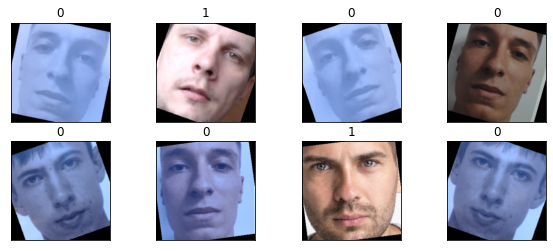

In [12]:
# Вспомогательная функция для денормализации и визуализации изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    plt.imshow(np.transpose(img, (1, 2, 0)))  # конвертация из тензора
    
# Получение пакета изображений обучающей выборки
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # преобразование изображений в формат numpy для визуализации

# Визуализация изображений, содержащихся в пакете, вместе с соответствующими метками категории
fig = plt.figure(figsize=(10, 4))
# Визуализация 8 изображений
for idx in np.arange(8):
    ax = fig.add_subplot(2, int(8/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [13]:
train_on_gpu = torch.cuda.is_available()
# Определение архитектуры сверточной нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Сверточный слой
        self.conv1 = nn.Conv2d(3, 16, 5)
        # Слой max pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        # Добавление последовательности сверточного слоя и слоя max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# Создание полной архитектуры сверточной нейронной сети
model = Net()
print(model)

# Перенос вычислений на видеокарту (GPU) в случае доступности CUDA
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [15]:
# Количество эпох для обучения модели
n_epochs = 300 # для обучения окончательной модели предпочтительно выбирать большие значения

valid_loss_min = np.Inf # отслеживание изменений функции потерь

for epoch in range(1, n_epochs+1):

    # Отслеживание изменений функции потерь на обучающей и тестовой выборках
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Обучение модели #
    ###################
    model.train()
    for data, target in train_loader:
        # Перенос вычислений на GPU в случае доступности CUDA
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Очистка градиента для всех оптимизируемых переменных
        optimizer.zero_grad()
        # Прямое распространение: вычисление предсказанных значений на выходном слое
        # путем передачи значений во входной слой модели
        output = model(data)
        # Вычисление функции потерь по пакету
        loss = criterion(output, target)
        # Обратное распространение: вычисление градиента функции потерь по отношению к параметрам модели
        loss.backward()
        # Выполнение одного шага оптимизации (обновление параметров)
        optimizer.step()
        # Обновление функции потерь на тренировочной выборке
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Валидация модели   #
    ######################
    model.eval()
    for data, target in valid_loader:
        # Перенос вычислений на GPU в случае доступности CUDA
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Прямое распространение: вычисление предсказанных значений на выходном слое
        # путем передачи значений во входной слой модели
        output = model(data)
        # Вычисление функции потерь по пакету
        loss = criterion(output, target)
        # Обновление среднего значения функции потерь на валидационной выборке
        valid_loss += loss.item()*data.size(0)
    
    # Обновление среднего значения функции потерь на обучающей и валидационной выборке
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # Получение текущего времени
    dt_now = datetime.datetime.now()
    current_time = dt_now.time()
    # Вывод текущего времени на печать
    print("Time: {0}".format(current_time))
    
    # Вывод на печать статистики по обучающей/валидационной выборке
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Сохранение модели в случае, если значение функции потерь на валидационной выборке уменьшилось
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Time: 21:07:44.518545
Epoch: 1 	Training Loss: 0.089219 	Validation Loss: 0.004875
Validation loss decreased (inf --> 0.004875).  Saving model ...
Time: 21:08:41.980591
Epoch: 2 	Training Loss: 0.036903 	Validation Loss: 0.004001
Validation loss decreased (0.004875 --> 0.004001).  Saving model ...
Time: 21:09:25.754440
Epoch: 3 	Training Loss: 0.035004 	Validation Loss: 0.003497
Validation loss decreased (0.004001 --> 0.003497).  Saving model ...
Time: 21:10:09.465135
Epoch: 4 	Training Loss: 0.145526 	Validation Loss: 0.005258
Time: 21:10:53.552200
Epoch: 5 	Training Loss: 0.083053 	Validation Loss: 0.006090
Time: 21:11:37.891077
Epoch: 6 	Training Loss: 0.038223 	Validation Loss: 0.003843
Time: 21:12:21.613766
Epoch: 7 	Training Loss: 0.035778 	Validation Loss: 0.003486
Validation loss decreased (0.003497 --> 0.003486).  Saving model ...
Time: 21:13:07.695043
Epoch: 8 	Training Loss: 0.028709 	Validation Loss: 0.002941
Validation loss decreased (0.003486 --> 0.002941).  Saving model 

Time: 22:12:28.813288
Epoch: 84 	Training Loss: 0.000327 	Validation Loss: 0.004312
Time: 22:13:16.234016
Epoch: 85 	Training Loss: 0.003741 	Validation Loss: 0.002599
Time: 22:14:03.503833
Epoch: 86 	Training Loss: 0.017822 	Validation Loss: 0.000786
Time: 22:14:51.371021
Epoch: 87 	Training Loss: 0.003246 	Validation Loss: 0.000177
Time: 22:15:48.487865
Epoch: 88 	Training Loss: 0.027427 	Validation Loss: 0.035426
Time: 22:16:35.737096
Epoch: 89 	Training Loss: 0.029568 	Validation Loss: 0.000504
Time: 22:17:22.767118
Epoch: 90 	Training Loss: 0.007423 	Validation Loss: 0.000711
Time: 22:18:10.111159
Epoch: 91 	Training Loss: 0.010025 	Validation Loss: 0.000463
Time: 22:18:57.328019
Epoch: 92 	Training Loss: 0.001674 	Validation Loss: 0.000129
Time: 22:19:44.698405
Epoch: 93 	Training Loss: 0.000651 	Validation Loss: 0.000044
Time: 22:20:32.093023
Epoch: 94 	Training Loss: 0.002457 	Validation Loss: 0.000423
Time: 22:21:19.654733
Epoch: 95 	Training Loss: 0.004328 	Validation Loss: 0

Time: 23:23:41.634440
Epoch: 175 	Training Loss: 0.003990 	Validation Loss: 0.000090
Time: 23:24:27.839671
Epoch: 176 	Training Loss: 0.000062 	Validation Loss: 0.000028
Time: 23:25:14.056139
Epoch: 177 	Training Loss: 0.006873 	Validation Loss: 0.000131
Time: 23:26:00.582552
Epoch: 178 	Training Loss: 0.000735 	Validation Loss: 0.000028
Time: 23:26:46.806776
Epoch: 179 	Training Loss: 0.000100 	Validation Loss: 0.000010
Time: 23:27:32.790469
Epoch: 180 	Training Loss: 0.003577 	Validation Loss: 0.000094
Time: 23:28:19.077121
Epoch: 181 	Training Loss: 0.000234 	Validation Loss: 0.000079
Time: 23:29:05.227433
Epoch: 182 	Training Loss: 0.000193 	Validation Loss: 0.000603
Time: 23:29:51.406442
Epoch: 183 	Training Loss: 0.000133 	Validation Loss: 0.000018
Time: 23:30:37.527398
Epoch: 184 	Training Loss: 0.000130 	Validation Loss: 0.000063
Time: 23:31:24.409875
Epoch: 185 	Training Loss: 0.002404 	Validation Loss: 0.001044
Time: 23:32:10.678497
Epoch: 186 	Training Loss: 0.003383 	Valida

Time: 00:37:22.734471
Epoch: 269 	Training Loss: 0.000002 	Validation Loss: 0.000039
Time: 00:38:09.135740
Epoch: 270 	Training Loss: 0.000003 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Time: 00:38:56.709681
Epoch: 271 	Training Loss: 0.000002 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Time: 00:39:44.190521
Epoch: 272 	Training Loss: 0.000002 	Validation Loss: 0.000002
Time: 00:40:30.413199
Epoch: 273 	Training Loss: 0.000002 	Validation Loss: 0.000000
Time: 00:41:16.954947
Epoch: 274 	Training Loss: 0.000002 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Time: 00:42:04.127193
Epoch: 275 	Training Loss: 0.000002 	Validation Loss: 0.000027
Time: 00:42:51.118191
Epoch: 276 	Training Loss: 0.000002 	Validation Loss: 0.000001
Time: 00:43:37.437702
Epoch: 277 	Training Loss: 0.000003 	Validation Loss: 0.000031
Time: 00:44:23.298827
Epoch:

In [16]:
# Оценка функции потерь на тестовой выборке
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# Выполняем оценку на тестовой выборке
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # Перенос вычислений на GPU в случае доступности CUDA
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # Прямое распространение: вычисление предсказанных значений на выходном слое
    # путем передачи значений во входной слой модели
    output = model(data)
    # Вычисление функции потерь по пакету
    loss = criterion(output, target)
    # Обновление функции потерь по пакету
    test_loss += loss.item()*data.size(0)
    # Вычисление выходных значений вероятности для прогнозирования класса
    _, pred = torch.max(output, 1)    
    # Сравнение предсказанных классов с действительными
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Вычисление точности для тестовой выборки
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Среднее значение функции потерь на тестовой выборке
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.083318

Test Accuracy of     0: 100% (832/832)
Test Accuracy of     1: 91% (792/864)

Test Accuracy (Overall): 95% (1624/1696)


In [ ]:
# Выполнение классификации на обученной нейронной сети

# Считывание изображения с помощью OpenCV
img_1 = cv2.imread('FD2.jpg', cv2.IMREAD_COLOR)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1 = Image.fromarray(img_1)

# Преобразование изображения к разрешению, с которым обучалась нейронная сеть
input_1 = transform(img_1)

# Добавление 4-го измерения к тензору, поскольку при обучении нейронной сети используются пакеты.
# Такая операция моделирует размер пакета, равный одному
input_1 = input_1[None, ...]

# Нейронная сеть была обучена с использованием cuda, поэтому перед классификацией входные данные
# также должны быть преобразованы в формат, поддерживаемый cuda
input_1 = input_1.cuda()

# Перевод модели в режим предсказания (вместо режима обучения)
# и отключение вычисления градиента
model.eval()
with torch.no_grad():
    output_1 = model(input_1)

# Возвращение модели в режим обучения
model.train()

# Поскольку тензор больше не нужен, он преобразуется в обычный список python
output_1 = output_1.tolist()[0]

# Определение полученного класса изображения как индекса максимального элемента списка
output_1 = np.argmax(output_1)

print(output_1)

In [17]:
# Сохранение обученной модели сверточной нейронной сети
torch.save(model.state_dict(), "D:/ML/Stepik/NN_CV/models/neural_network_2021_12_12.pth")